In [1]:
%load_ext autoreload
%autoreload 2
import pytest
import re, os

import torch
from torch.utils.data import DataLoader
import torchvision

import modlee
from modlee import data_metafeatures as dmf
from modlee.utils import text_loaders, image_loaders

import numpy as np
import pandas as pd
import spacy
import karateclub

import torch_geometric
import matplotlib.pyplot as plt
import networkx as nx 
import onnx
from onnx.tools import net_drawer
import matplotlib as mpl
import copy
# import torch_geometric as pyg
import numpy as np
import torch_geometric as pyg
# from torch_geometric.utils import convert
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from transformers import GraphormerForGraphClassification
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import argparse
import os.path as osp
import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import DimeNet, DimeNetPlusPlus

DATA_ROOT = os.path.expanduser("~/efs/.data")
IMAGE_DATALOADER = modlee.utils.get_imagenette_dataloader()
# TEXT_DATALOADER = modlee.utils.get_wnli_dataloader() 


TEXT_LOADERS = {loader_fn:getattr(text_loaders, loader_fn) for loader_fn in dir(text_loaders) if re.match('get_(.*)_dataloader', loader_fn)}
IMAGE_LOADERS = [getattr(image_loaders, loader_fn) for loader_fn in dir(image_loaders) if re.match('get_(.*)_dataloader', loader_fn)]

# things to install:
# torch_geometric, pydot, transformers

/home/ubuntu/.conda/envs/modlee3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/.conda/envs/modlee3.12/lib/python3.12/site-packages/modlee/converter.py:354: SyntaxWarning: invalid escape sequence '\('
  "makrograph-edge\((\d*),(\d*)\)_",
/home/ubuntu/.conda/envs/modlee3.12/lib/python3.12/site-packages/modlee/converter.py:535: SyntaxWarning: invalid escape sequence '\['
  bool_dim = re.search("bool\[(?P<bool_dim>.*)\]", input_str)
/home/ubuntu/.conda/envs/modlee3.12/lib/python3.12/site-packages/modlee/converter.py:577: SyntaxWarning: invalid escape sequence '\s'
  return re.sub("([\s(,]+)(\d+)_*([a-zA-Z0-9]*)[\s_=]", "\\1\\3_\\2_", input_str)
/home/ubuntu/.conda/envs/modlee3.12/lib/python3.12/site-packages/modlee/converter.py:1044: SyntaxWarning: invalid escape sequence '\)'
  "(Tile.*),

ModuleNotFoundError: No module named 'pydot'

In [7]:
# Only need to run if the environment does not have torch-{scatter,sparse,cluster}
!which pip3
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster --y
!pip install --no-cache torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install  --no-cache torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install  --no-cache torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip3 install transformers pydot torch_geometric

/home/ubuntu/.conda/envs/modlee312/bin/pip3
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 8.7 MB/s eta 0:00:00a 0:00:010m
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-jxmo42r3
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-jxmo42r3
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit e9648df16dcb6dde0e09b5736b1b2da5d68db2ad
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
def get_imports():
    # !cat metafeatures.ipynb | grep import
    with open('./metafeatures.ipynb','r') as _f:
        l = _f.readlines()
    # print('\n'.join(l[:100]))
        
    l = [_l.strip().replace('\\n','').replace('"','').replace(',','') for _l in l if 'import' in _l]
    # print(l)
    # print('\n'.join(l))
    return '\n'.join(l)

In [30]:
mf_global = None
def get_df_from_loaders(loaders, modality, n_samples=1):
    global mf_global
    if isinstance(loaders, dict):
        loaders = list(loaders.values())
    df = pd.DataFrame()
    print(loaders)
    features = []
    MFClass = getattr(dmf, f"{modality.capitalize()}DataMetafeatures")
    for loader_fn in loaders:
        for _ in range(n_samples):
            metafeatures = MFClass(
                loader_fn(root=DATA_ROOT), testing=True
            )
            if hasattr(loader_fn, 'args'):
                dataset_name = loader_fn.args[0]
            else:
                dataset_name = loader_fn.__name__
            mf_global = metafeatures
            features.append({
                    'dataset_name':dataset_name,
                    **metafeatures.embedding,
                    **metafeatures.mfe,
                    **metafeatures.properties,
            })
            pd.DataFrame(features[-1]).to_csv(
                f'./{modality}_features_cache.csv',
                mode='a')
    df = pd.DataFrame(features)
    return df



In [8]:
from modlee.dataframes import ModleeDataFrame, default_transforms
model_mf_df = ModleeDataFrame(model_mf_list)
modlee_mf_df = default_transforms(model_mf_df)

NameError: name 'model_mf_list' is not defined

In [ ]:
text_df = MFDF(pd.read_csv('./text_features_cache.csv'))
image_df = MFDF(pd.read_csv('./image_features_cache.csv'))
concat_df = MFDF(pd.concat([text_df, image_df], ignore_index=True))
# text_df.save_labels('./labels_test.txt')
print(concat_df)
print(concat_df.name)
concat_df.save_labels()

In [ ]:

text_df = MFDF(df_transforms(text_df))
text_df.save_tsv('./test_text.tsv')
print(text_df)

In [ ]:
# import test_model_metafeatures
%load_ext autoreload
%autoreload 2
import os, sys
os.getcwd()
sys.path.insert(0, '..')
# from tests import test_model_metafeatures
# import tests
# print(dir(tests))
# print(tests)
import test_model_metafeatures
# tests.test
# from test_model_metafeatures import *
tmm = test_model_metafeatures.TestModelMetafeatures()
image_mf = tmm.test_image_model_metafeatures(test_model_metafeatures.IMAGE_MODELS[0])


In [ ]:
# help(image_mf)
# TODO - consider making the metafeatures a subclass of dataframes themselves
# image_mf.dataframe
image_mf.get_parameter_statistics(image_mf.dataframe['conv_dilations_0'])
print(image_mf.dataframe.select_dtypes(include='float'))
print(image_mf.dataframe.shape)
image_mf.get_propertie

In [3]:
%load_ext autoreload
%autoreload 2
from conftest import IMAGE_MODELS, IMAGE_SEGMENTATION_MODELS


models = IMAGE_MODELS + IMAGE_SEGMENTATION_MODELS
from modlee import model_metafeatures as mmf
model_mfs = []
for model in IMAGE_MODELS:
    model_mf = mmf.ImageModelMetafeatures(model)
    model_mfs.append(model_mf)
for model in IMAGE_SEGMENTATION_MODELS:
    model_mf = mmf.ImageSegmentationModelMetafeatures(model)
    model_mfs.append(model_mf)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/ubuntu/.conda/envs/modlee312/lib/python3.12/site-packages/torchtext/models/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ubuntu/.conda/envs/modlee312/lib/python3.12/site-packages/torchtext/transforms.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ubuntu/.conda/envs/modlee312/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarni

In [35]:
model_labels = [
    'clf_resnet18_pretrained',
    'clf_resnet18',
    'clf_resnet50',
    'clf_resnet152',
    'seg_fcn_resnet50',
    'seg_fcn_resnet101',
    'seg_lraspp_mobilenet_v3_large',
    'seg_deeplabv3_resnet50',
    'seg_deeplabv3_resnet101',
]
models[0].__dir__()
# models[0]._get_name()

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_impl',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_make_layer',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_memb

In [13]:
import inspect
print(inspect.getsource(model_mf.__init__))
model_mf.get_embedding()
for model_mf in model_mfs:
    model_mf.embedding = model_mf.embeddings

    def __init__(self, torch_model: torch.nn.Module, *args, **kwargs):
        #  Should work with any of the available model representations
        # Torch model/text, ONNX graph/text
        # Store these different representations
        self.torch_model = torch_model
        self.onnx_graph = converter.torch_model2onnx_graph(
            self.torch_model
        )
        # Must calculate NetworkX before initializing tensors
        self.onnx_nx = converter.index_nx(
            converter.onnx_graph2onnx_nx(
                self.onnx_graph
        ))
        self.onnx_text = converter.onnx_graph2onnx_text(self.onnx_graph)
        self.onnx_graph = converter.init_onnx_tensors(
            converter.init_onnx_params(
                self.onnx_graph
            )
        )
        
        self.dataframe = self.get_graph_dataframe(self.onnx_graph)
        self.properties = self.get_properties()
        self.embeddings = self.get_embedding()
        pass



/home/ubuntu/.conda/envs/modlee312/lib/python3.12/site-packages/karateclub/estimator.py:66: UserWarning: Please do be advised that the graph you have provided does not contain (some) edges in the main diagonal, for instance the self-loop constitued of (0, 0). These selfloops are necessary to ensure that the graph is traversable, and for this reason we create a copy of the graph and add therein the missing edges. Since we are creating a copy, this will immediately duplicate the memory requirements. To avoid this double allocation, you can provide the graph with the selfloops.
  warnings.warn(


{'embd_0': 0.31196684,
 'embd_1': -0.13048755,
 'embd_2': -0.23547895,
 'embd_3': -0.1046185,
 'embd_4': -0.16155484,
 'embd_5': -0.0060918448,
 'embd_6': 0.110071965,
 'embd_7': -0.28069374,
 'embd_8': -0.16768284,
 'embd_9': -0.03657363,
 'embd_10': 0.14379497,
 'embd_11': 0.1822052,
 'embd_12': -0.0034986995,
 'embd_13': 0.213183,
 'embd_14': 0.047922615,
 'embd_15': -0.06087632,
 'embd_16': 0.054494657,
 'embd_17': 0.05638334,
 'embd_18': -0.17757621,
 'embd_19': 0.16681549,
 'embd_20': -0.1442158,
 'embd_21': -0.21799125,
 'embd_22': 0.087584496,
 'embd_23': 0.006274946,
 'embd_24': 0.0064659547,
 'embd_25': -0.109127015,
 'embd_26': 0.26742074,
 'embd_27': -0.06537563,
 'embd_28': -0.087547764,
 'embd_29': 0.020294983,
 'embd_30': 0.05076538,
 'embd_31': 0.15639642,
 'embd_32': 0.007632737,
 'embd_33': 0.11286494,
 'embd_34': -0.040336784,
 'embd_35': -0.129337,
 'embd_36': 0.09923463,
 'embd_37': 0.056437753,
 'embd_38': 0.24824236,
 'embd_39': 0.07697988,
 'embd_40': -0.0168544

In [15]:
model_mf_df = pd.DataFrame(
    # [{**model_mf.properties, **{f"embd_{i}":e for i,e in enumerate(model_mf.embedding[0])}} for model_mf in model_mfs]
    [{**model_mf.properties, **model_mf.embedding} for model_mf in model_mfs]
)

In [36]:
%load_ext autoreload
%autoreload 2
import modlee
from modlee.dataframes import default_transforms
# model_mf_df
# model_mf_df.select_dtypes(include=['object']).columns
model_df = default_transforms(model_mf_df)
# model_mf_df
model_df['labels'] = model_labels



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
model_df.to_csv("../src/modlee/model_metafeatures.csv")

In [41]:
models[0].__dir__()
with open('model_mf_labels.txt','w') as _file:
    model_sizes = list(model_df['size'].apply(lambda x: f"model_{x}"))
    _file.write('\n'.join(model_sizes))
    # _file.writelines(model_df['size'].apply(lambda x: f"model_{x}"))
model_df_props = model_df[[col for col in model_df.columns if 'embd' not in col]]

model_df.to_csv(
'model_embd.tsv',
    sep='\t',
    index=False,
    header=False
)
model_df_props.to_csv(
'model_props_embd.tsv',
    sep='\t',
    index=False,
    header=False
)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_impl',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_make_layer',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_memb

195

In [ ]:
for model_mf in model_mfs:
    print(model_mf['conv_count'])
df_model = pd.DataFrame([model_mf for model_mf in model_mfs])
print(df_model['model_name'])
df_model['dataset_name']

In [ ]:
# df_model
count_cols = [col for col in df_model.columns if 'count' in col]
print(count_cols)
df_model['dataset_name'] = df_model[count_cols].sum(axis=1)
df_model['dataset_name'] = df_model['dataset_name'].apply(str)
name_cols = ['dataset_name','model_name']
# df_model['dataset_name'] = df_model[name_cols].apply(lambda x: ' '.join(x))
df_model['dataset_name'] = df_model['model_name'] + df_model['dataset_name']
print(df_model[['dataset_name','model_name']])
save_labels(df_model, f'./model_labels.txt')
norm_model = df_transforms(df_model)
norm_model

save_tsv(norm_model, f'model_metafeatures.tsv')

In [ ]:
from datasets import load_dataset

# There is only one split on the hub
dataset = load_dataset("OGB/ogbg-molhiv")

dataset = dataset.shuffle(seed=0)

import networkx as nx
import matplotlib.pyplot as plt

# We want to plot the first train graph
graph = dataset["train"][0]

edges = graph["edge_index"]
num_edges = len(edges[0])
num_nodes = graph["num_nodes"]

# Conversion to networkx format
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(num_edges)])

# Plot
nx.draw(G)


In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("graph-ml", model="clefourrier/graphormer-base-pcqm4mv2")

# ONNX -> PyG starts below

In [2]:
from conftest import IMAGE_MODELS, IMAGE_SEGMENTATION_MODELS
model = IMAGE_SEGMENTATION_MODELS[2]
model = IMAGE_MODELS[0]
import modlee
converter = modlee.converter.Converter()

onnx_graph = converter.torch_model2onnx_graph(model)
models = IMAGE_MODELS + IMAGE_SEGMENTATION_MODELS

/home/ubuntu/.conda/envs/modlee312/lib/python3.12/site-packages/torchtext/models/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ubuntu/.conda/envs/modlee312/lib/python3.12/site-packages/torchtext/transforms.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ubuntu/.conda/envs/modlee312/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarni

In [2]:
%load_ext autoreload
%autoreload 2
# onnx_graph
# dir(onnx_graph)
# print(dir(onnx_graph))
import torch_geometric
import matplotlib.pyplot as plt
# ax = plt.axes([0,0,5,10])
import networkx as nx 
import onnx
from onnx.tools import net_drawer
# print(onnx_graph.node)

def filter_node(x):
    return 'onnx::' in x \
        or 'Identity' in x \
        or 'fc.' in x
        
def prune_onnx_nx(onnx_nx):
    nodes_to_prune = [k for k in onnx_nx.nodes.keys() if filter_node(k)]
    # help(onnx_nx.remove_node)
    onnx_nx_layers_only = copy.deepcopy(onnx_nx)
    for node in nodes_to_prune:
        onnx_nx_layers_only.remove_node(node)
    return onnx_nx_layers_only
        
def onnx_graph2onnx_nx(onnx_graph, prune=True):
    onnx_pydot = onnx.tools.net_drawer.GetPydotGraph(
        converter.onnx_parameterless2onnx(onnx_graph).graph)
    onnx_pydot.set_name("onnx_graph")
    onnx_nx = nx.nx_pydot.from_pydot(onnx_pydot)
    if prune:
        onnx_nx = prune_onnx_nx(onnx_nx)
    return onnx_nx
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
onnx_nxs = []
for model in models:
    onnx_nxs.append(onnx_graph2onnx_nx(
        converter.torch_model2onnx_graph(model)
    ))

In [10]:
onnx_nxs_bak = copy.deepcopy(onnx_nxs)
for onnx_nx in onnx_nxs_bak:
    relabel_dict ={}
    for n,node in enumerate(onnx_nx.nodes(data=True)):
        # print(node[0])
        relabel_dict.update({node[0]:n})
        # print(type(node))
        # node[1]['index'] = n
        # print(node)
    nx.relabel_nodes(onnx_nx, relabel_dict, copy=False)
    # onnx_nx.adjacency_matrix
    
print(relabel_dict)
    
print(onnx_nx.nodes)

{'/Shape/Shape (op#6)\\n input0 input_1\\n output0 /Shape_output_0': 0, 'input_10': 1, '/Shape_output_00': 2, '/Constant/Constant (op#7)\\n output0 /Constant_output_0': 3, '/Constant_output_00': 4, '/Gather/Gather (op#8)\\n input0 /Shape_output_0\\n input1 /Constant_output_0\\n output0 /Gather_output_0': 5, '/Gather_output_00': 6, '/Shape_1/Shape (op#9)\\n input0 input_1\\n output0 /Shape_1_output_0': 7, '/Shape_1_output_00': 8, '/Constant_1/Constant (op#10)\\n output0 /Constant_1_output_0': 9, '/Constant_1_output_00': 10, '/Gather_1/Gather (op#11)\\n input0 /Shape_1_output_0\\n input1 /Constant_1_output_0\\n output0 /Gather_1_output_0': 11, '/Gather_1_output_00': 12, '/backbone/conv1/Conv/Conv (op#12)\\n input0 input_1\\n input1 onnx': 13, '/backbone/conv1/Conv_output_00': 14, '/backbone/relu/Relu/Relu (op#13)\\n input0 /backbone/conv1/Conv_output_0\\n output0 /backbone/relu/Relu_output_0': 15, '/backbone/relu/Relu_output_00': 16, '/backbone/maxpool/MaxPool/MaxPool (op#14)\\n input0 /

In [17]:
# dir(onnx_nx)
# onnx_nx.adjacency
# onnx_nx.adj
nx.adjacency_matrix(onnx_nx).todense()

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [47]:

g = nx.newman_watts_strogatz_graph(100, 20, 0.05)
# print(g.nodes)
print(onnx_nx.nodes)

['/conv1/Conv/Conv (op#0)\\n input0 input_1\\n input1 onnx', 'input_10', '/conv1/Conv_output_00', '/relu/Relu/Relu (op#1)\\n input0 /conv1/Conv_output_0\\n output0 /relu/Relu_output_0', '/relu/Relu_output_00', '/maxpool/MaxPool/MaxPool (op#2)\\n input0 /relu/Relu_output_0\\n output0 /maxpool/MaxPool_output_0', '/maxpool/MaxPool_output_00', '/layer1/layer1.0/conv1/Conv/Conv (op#3)\\n input0 /maxpool/MaxPool_output_0\\n input1 onnx', '/layer1/layer1.0/conv1/Conv_output_00', '/layer1/layer1.0/relu/Relu/Relu (op#4)\\n input0 /layer1/layer1.0/conv1/Conv_output_0\\n output0 /layer1/layer1.0/relu/Relu_output_0', '/layer1/layer1.0/relu/Relu_output_00', '/layer1/layer1.0/conv2/Conv/Conv (op#5)\\n input0 /layer1/layer1.0/relu/Relu_output_0\\n input1 onnx', '/layer1/layer1.0/conv2/Conv_output_00', '/layer1/layer1.0/Add/Add (op#6)\\n input0 /layer1/layer1.0/conv2/Conv_output_0\\n input1 /maxpool/MaxPool_output_0\\n output0 /layer1/layer1.0/Add_output_0', '/layer1/layer1.0/Add_output_00', '/layer1/

In [19]:
%load_ext autoreload
%autoreload 2


import karateclub
g2v = karateclub.graph2vec.Graph2Vec()
# g2v.fit(onnx_nxs_bak)
# g2v.fit(g)
from modlee.model_metafeatures import ModelEncoder
g2v_mfe = ModelEncoder()
g2v_mfe.fit(onnx_nxs_bak)
g2v_mfe.save('./g2v.pkl')

/home/ubuntu/.conda/envs/modlee312/lib/python3.12/site-packages/karateclub/estimator.py:66: UserWarning: Please do be advised that the graph you have provided does not contain (some) edges in the main diagonal, for instance the self-loop constitued of (0, 0). These selfloops are necessary to ensure that the graph is traversable, and for this reason we create a copy of the graph and add therein the missing edges. Since we are creating a copy, this will immediately duplicate the memory requirements. To avoid this double allocation, you can provide the graph with the selfloops.
  warnings.warn(
INFO:collecting all words and their counts
INFO:PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
INFO:collected 83 word types and 9 unique tags from a corpus of 9 examples and 9897 words
INFO:Creating a fresh vocabulary
INFO:Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 52 unique words (62.65% of original 83, drops 31)', 'datetime': '2024-05-22T15:45:01.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
%load_ext autoreload
%autoreload 2

# g2v_rl = ModelEncoder.from_pkl('./g2v.pkl')
g2v_mfe.get_params()
g2v.set_params(**g2v_mfe.get_params())
import modlee
from modlee.model_metafeatures import ModelEncoder
import inspect
import pickle
print(inspect.getsource(ModelEncoder.from_pkl))
# g2v_me = ModelEncoder.from_pkl('./g2v.pkl')
with open('./g2v.pkl', 'rb') as _file:
    g2v_rl = pickle.load(_file)
type(g2v_rl)
g2v_rl.infer(onnx_nxs_bak)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of modlee.model_metafeatures failed: Traceback (most recent call last):
  File "/home/ubuntu/.conda/envs/modlee312/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/ubuntu/.conda/envs/modlee312/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/ubuntu/.conda/envs/modlee312/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 995, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/ubuntu/.conda/envs/modlee312/lib/python3.12/site-packages/modlee/model_metafeatures.py", line 11, in <module>
    converter = modlee.converter.Converter()
                ^^^^^^^^^^^^^^^^
Attrib

{'wl_iterations': 2,
 'use_node_attribute': None,
 'dimensions': 128,
 'workers': 4,
 'down_sampling': 0.0001,
 'epochs': 10,
 'learning_rate': 0.025,
 'min_count': 5,
 'seed': 42,
 'erase_base_features': False,
 'model': <gensim.models.doc2vec.Doc2Vec at 0x7f2ca4f6fb90>}

    def save(self, path):
        with open(path, 'wb') as _file:
            _file.write(pickle.dumps(self))



modlee.model_metafeatures.ModelEncoder

/home/ubuntu/.conda/envs/modlee312/lib/python3.12/site-packages/karateclub/estimator.py:66: UserWarning: Please do be advised that the graph you have provided does not contain (some) edges in the main diagonal, for instance the self-loop constitued of (0, 0). These selfloops are necessary to ensure that the graph is traversable, and for this reason we create a copy of the graph and add therein the missing edges. Since we are creating a copy, this will immediately duplicate the memory requirements. To avoid this double allocation, you can provide the graph with the selfloops.
  warnings.warn(


array([[ 0.22545156, -0.09464288, -0.17315903, ..., -0.00821528,
        -0.02875592, -0.00988017],
       [ 0.22960028, -0.09654257, -0.17630087, ..., -0.00852752,
        -0.02949054, -0.01046936],
       [ 0.233899  , -0.09961917, -0.17999695, ..., -0.01243607,
        -0.02978834, -0.01627886],
       ...,
       [ 0.38982266, -0.17631257, -0.31545722, ..., -0.02178403,
        -0.04004664, -0.01922835],
       [ 0.34374988, -0.14821137, -0.25971365, ..., -0.01220447,
        -0.0451714 , -0.0208948 ],
       [ 0.3110027 , -0.13364235, -0.23361671, ..., -0.00931154,
        -0.04302771, -0.01586122]], dtype=float32)

In [7]:
import modlee
os.path.exists(modlee.config.G2V_PKL)
os.listdir(os.path.dirname(modlee.config.G2V_PKL))
from modlee.model_metafeatures import ModelEncoder
t = ModelEncoder.from_pkl(modlee.config.G2V_PKL)
import inspect
print(inspect.getsource(ModelEncoder))

True

['model_metafeatures.py',
 '__pycache__',
 'retriever.py',
 'g2v.pkl',
 'model_text_converter.py',
 'config.py',
 'client.py',
 'trainer.py',
 'loss_sweeper.py',
 'model',
 '__init__.py',
 'utils.py',
 'exp_loss_logger.py',
 'modlee_image_model.py',
 'converter.py',
 'recommender',
 'data_metafeatures.py']

AttributeError: module 'modlee' has no attribute 'converter'

In [1]:
import pickle
# pickle.dumps(g2v)
g2v_rl = pickle.loads(pickle.dumps(g2v))
dir(g2v)
# g2v_rl.get_params()


NameError: name 'g2v' is not defined

In [70]:
# for onnx_nx in onnx_nxs_bak:
#     print(onnx_nx)
#     g2v.infer([onnx_nx])
graph_embds = g2v.infer(onnx_nxs_bak)
graph_embds = np.array(graph_embds)
print(graph_embds.shape)
print(graph_embds[...,:2])
graph_embds.std(axis=0)

(9, 128)
[[-0.00105674  0.00207241]
 [ 0.00077086  0.00120153]
 [ 0.00212177  0.00226101]
 [-0.00295678 -0.00129032]
 [ 0.00299434 -0.00307984]
 [ 0.0028862  -0.00365495]
 [ 0.00366727 -0.00284002]
 [ 0.00161454 -0.00362909]
 [ 0.00329536  0.00059563]]


array([0.0020924 , 0.00233757, 0.00243714, 0.00171691, 0.00210903,
       0.00205651, 0.0019765 , 0.00207881, 0.00183127, 0.00234839,
       0.00150817, 0.00188816, 0.00205166, 0.00180361, 0.00203067,
       0.00204342, 0.0014617 , 0.00201847, 0.00248629, 0.00265794,
       0.00245506, 0.00221734, 0.00243728, 0.00224482, 0.00204721,
       0.00193488, 0.00168973, 0.00131468, 0.00150243, 0.00254576,
       0.00188076, 0.00229063, 0.00222308, 0.00196838, 0.0016687 ,
       0.00215539, 0.00212319, 0.00206592, 0.0020287 , 0.00228454,
       0.00200407, 0.00228356, 0.00180469, 0.00162153, 0.00184982,
       0.00238861, 0.00240034, 0.00169113, 0.00210505, 0.00264343,
       0.00135907, 0.00178642, 0.00231827, 0.00177731, 0.00199053,
       0.00246064, 0.00167716, 0.00167195, 0.00232026, 0.00191732,
       0.00250698, 0.00181417, 0.00221422, 0.00192077, 0.00231814,
       0.0016966 , 0.00252831, 0.0019067 , 0.00212087, 0.00192985,
       0.00212536, 0.00205462, 0.00250567, 0.00261688, 0.00203

In [ ]:

# dir(onnx_nx)
import matplotlib as mpl
import copy
nodes_to_prune = [k for k in onnx_nx.nodes.keys() if filter_node(k)]
# help(onnx_nx.remove_node)
onnx_nx_layers_only = copy.deepcopy(onnx_nx)
for node in nodes_to_prune:
    onnx_nx_layers_only.remove_node(node)
print(onnx_nx_layers_only.nodes)
# pc = mpl.collections.PatchCollection(edges, cmap=cmap)
# pc.set_array(edge_colors)
# ax.show()
plt.show()
dir(onnx_nx_layers_only.edges)
# print(onnx_nx_layers_only.edges.keys())
e0 = onnx_nx_layers_only.edges.items()
print(e0)
onnx_nx.is_directed()
# print(onnx_nx.selfloop_edges)
n0 = list(onnx_nx.nodes.items())[0]
# print(n0[1])


In [ ]:
nodes_to_remove = []
for node_name, node_data in onnx_nx_layers_only.nodes.items():
    print(node_name)
    print(node_data)
    # if 'fontcolor' not in node_data:
    # if 'label' not in node_data:
    # if 'style' in node_data:
    #     nodes_to_remove.append(node_name)
        # onnx_nx_layers_only.remove_node(node_name)
    print('\n')

print(nodes_to_remove)
for node_to_remove in nodes_to_remove:
    onnx_nx_layers_only.remove_node(node_to_remove)
# n0 = onnx_nx.nodes[onnx_nx.nodes.keys()]
# edge_colors = range(2,onnx_nx_layers_only.number_of_edges()+2)


In [ ]:

nx_drawing = nx.draw_networkx(onnx_nx_layers_only,
    pos=nx.spring_layout(onnx_nx_layers_only, seed=64),
    # pos=nx.bipartite_layout(onnx_nx),
    with_labels=False,
    node_size=10,
    # edge_color=edge_colors,
    # edge_cmap=plt.cm.plasma
    # ax=ax
)
print(onnx_nx_layers_only.edges)


In [ ]:
dir(onnx_nx)
# dir(onnx_nx.nodes)

In [ ]:
for node_name, node_data in onnx_nx.nodes.items():
    # type(node_data)
    print(onnx_nx.nodes[node_name])

In [ ]:
# import torch_geometric as pyg
import numpy as np
import torch_geometric as pyg
# print(pyg.__version__)
# dir(pyg)
# dir(torch_geometric.torch_geometric)
# from torch_geometric.utils import convert
onnx_test = copy.deepcopy(onnx_nx_layers_only)
# nx.set_node_attributes(onnx_test, None, "label")
edge_dict = {'shape': 'box', 'color': '#0F9D58', 'style': 'filled', 'fontcolor': '#FFFFFF', 'label': None}
for k in edge_dict.keys():
    # nx.set_node_attributes(onnx_test, None, k)
    # nx.set_node_attributes(onnx_test, np.random.rand(98)*100, k)
    nx.set_node_attributes(onnx_test, np.random.rand()*100, k)
    nx.set_node_attributes(onnx_test, np.random.rand()*100, f"edge_{k}")
# dir(onnx_test.edges.items()[0])
onnx_test.edges
# for edge_name,edge_data in onnx_test.edges.items():
#     print(edge_data)
# nx.get_edge_attributes(onnx_test)
nx.draw_networkx(onnx_test,
    with_labels=False,
        node_size=10,
    )
# for node,node_data in onnx_test.nodes.items():
#     print(node_data)
onnx_pyg = pyg.utils.convert.from_networkx(
    onnx_test,
    group_node_attrs=['label'],
    group_edge_attrs=['shape']
    )
# !ls
# onnx_pyg.label
# dir(onnx_pyg)
# onnx_pyg.fully_specify()
# onnx_pyg.x
# onnx_pyg.get_tensor()
# onnx_pyg.num_node_features

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# dir(onnx_pyg)
onnx_pyg.edge_attrs()
onnx_pyg.is_directed()
# onnx_pyg.num_nodes  
# onnx_pyg.num_node_features

In [ ]:
from transformers import GraphormerForGraphClassification

model = GraphormerForGraphClassification.from_pretrained(
    "clefourrier/pcqm4mv2_graphormer_base",
    num_classes=1, # num_classes for the downstream task 
    ignore_mismatched_sizes=True,
)



In [ ]:
model(onnx_pyg)

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch_geometric.nn import GCNConv

from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
# dataset = DataLoader([onnx_pyg])

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = GCNConv(dataset.num_node_features, 16)
        # self.conv2 = GCNConv(16, dataset.num_classes)
        # self.conv1 = GCNConv(98, 16)
        # self.conv1 = GCNConv(98, 1)
        self.conv1 = GCNConv(1, 16)
        # self.conv2 = GCNConv(16, dataset.num_classes)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

gcn = GCN()


In [ ]:
type(dataset)
type(onnx_pyg)

In [ ]:
# dataset[0].__dict__
# dir(dataset[0])
# dataset=dataset[0]
len(dataset)
d0 = dataset[0]
# dir(d0)
d0.keys()
# d0.num_nodes
# d0.edge_index = d0.edge_index[...,:-4]
d0.num_node_features
d0.get_all_tensor_attrs()
d0.node_attrs()
d0.edge_attrs()
d0.edge_attr
len(d0.edge_index[0])
# d0.pos.shape
d0.x.shape
d0.y.shape
d0_nx = pyg.utils.convert.to_networkx(
    d0
)
d0_sub = d0_nx.subgraph(list(range(1000)))
layout_type = 'random'
layout_type = 'spectral'
layout_type = 'spring'
nx.draw_networkx(
    d0_sub,
    pos=getattr(nx, f"{layout_type}_layout")(d0_sub),
    font_color="white",
    # font_size=0,
    arrows=False,
    with_labels=False,
    node_size=2,
    edge_color=(0,0,0,0.23)
    )
# d0.x
# d0.edge_index
len(d0.edge_index[0])

# CORA Citation network
Nodes are papers, edges are citations

In [ ]:
# dir(pyg.nn.models)
# pyg_unet = pyg.nn.models.GraphUNet()
pyg_models = pyg.nn.models
for pyg_model in dir(pyg_models):
    # print(pyg_model)
    # dir(pyg_model)
    if 'pretrained' in ' '.join((dir(getattr(pyg_models,pyg_model)))):
        print(pyg_model)

In [ ]:
import argparse
import os.path as osp

import torch

from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import DimeNet, DimeNetPlusPlus

Model = DimeNetPlusPlus

# path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'QM9')
path = osp.join(osp.dirname(osp.abspath('')), '..', 'data', 'QM9')
qm9_dataset = QM9(path)


In [ ]:
len(qm9_dataset)
q0 = pyg.utils.convert.to_networkx(qm9_dataset[10])
# # print(q0.node_attrs())
# for q in qm9_dataset[:10]:
    # print(q.x)
nx.draw_networkx(q0,
    font_color="white",
    )

# QM9 Quantum chemical properties

In [ ]:

# DimeNet uses the atomization energy for targets U0, U, H, and G, i.e.:
# 7 -> 12, 8 -> 13, 9 -> 14, 10 -> 15
idx = torch.tensor([0, 1, 2, 3, 4, 5, 6, 12, 13, 14, 15, 11])
qm9_dataset.data.y = qm9_dataset.data.y[:, idx]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:

# for target in range(12):
for target in range(1):
    # Skip target \delta\epsilon, since it can be computed via
    # \epsilon_{LUMO} - \epsilon_{HOMO}:
    if target == 4:
        continue

    # model, datasets = pyg.nn.SchNet.from_qm9_pretrained(path, qm9_dataset, target)
    model, datasets = Model.from_qm9_pretrained(path, qm9_dataset, target)
    train_dataset, val_dataset, test_dataset = datasets

    model = model.to(device)
    loader = DataLoader(test_dataset, batch_size=2)

    maes = []
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data.z, data.pos, data.batch)
        mae = (pred.view(-1) - data.y[:, target]).abs()
        maes.append(mae)

    mae = torch.cat(maes, dim=0)

    # Report meV instead of eV:
    mae = 1000 * mae if target in [2, 3, 4, 6, 7, 8, 9, 10] else mae

    print(f'Target: {target:02d}, MAE: {mae.mean():.5f} ± {mae.std():.5f}')

In [ ]:
x_tr = next(iter(DataLoader(train_dataset,batch_size=3)))
x_tr[0]
x_tr[1]
nx.draw_networkx(pyg.utils.convert.to_networkx(x_tr))

In [ ]:
# x_tr0 = train_dataset[0]
import random
from random import shuffle
len(train_dataset)
x_tr0 = random.choice(train_dataset)
# dir(x_tr0)
x_tr0
x_tr0.num_features
nx.draw_networkx(pyg.utils.convert.to_networkx(x_tr0), font_color="white")
#_tr0.z
# x_tr0.pos
print(x_tr0.z.shape)
print(x_tr0.pos.shape)
print(x_tr0.batch)
bs = 10
z_dummy = torch.randint(low=0,high=7,size=(bs,bs,))
model(
    z_dummy.to(device),
    # torch.randint((bs),dtype=torch.int64).to(device),
    torch.randn((bs,bs,3)).to(device),
    None
)
# The {Dime,Sch}Nets take as input the QM9 dataset:
# http://quantum-machine.org/datasets/
# - z (num_nodes) - the classes of the nodes?
# - pos (num_nodes, 3) - 3D positions. Why is this not the features (num_features=11)?

In [ ]:
model(qm9_dataset[0])

In [ ]:
# !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git



In [ ]:
torch.cuda.is_available()

In [ ]:
torch.__version__

In [ ]:
# dataset[0].num_node_features
dataset[0].edge_index
# dataset[0].num_features
# dataset[0].x
onnx_pyg.edge_index
# onnx_pyg.x
type(dataset[0]); type(onnx_pyg)
onnx_pyg.x.max()
onnx_pyg.num_nodes
# onnx_pyg.num_node_features = onnx_pyg.num_nodes
onnx_pyg.num_node_features
# [onnx_pyg].num_node_features
# type(dataset)
# help(torch_geometric.datasets)
# gcn(dataset[0])
# pyg_data = onnx_pyg.unsqueeze(-1)
BATCH_SIZE = 32
class PyGDataset(torch.utils.data.Dataset):
    def __init__(self, *args, **kwargs):
        pass
    
    def __len__(self):
        return BATCH_SIZE
    
    def __getitem__(self, idx):
        return onnx_pyg


pyg_dataset = DataLoader(PyGDataset(), batch_size=BATCH_SIZE)
# pyg_batch = next(iter(pyg_dataset))
# [torch.Tensor(onnx_pyg)]*10
# onnx_pyg*10
pyg_batch_list = pyg.data.Batch.from_data_list([onnx_pyg]*32)
gcn_out = gcn(pyg_batch_list)
# gcn_out = gcn(torch.Tensor(onnx_pyg))
gcn_out.shape
gcn_out

In [ ]:
gcn.state_dict()

# ONNX -> PyDot -> NetworkX -> PyG

In [ ]:
onnx_pyg_nx = pyg.utils.convert.to_networkx(
    onnx_pyg,
    
)

nx.draw_networkx(onnx_pyg_nx,
    pos=nx.spring_layout(onnx_pyg_nx, seed=64),
    with_labels=False,
    node_size=10)

# for node_name, node_data in onnx_pyg_nx.nodes.items():
#     print(node_data)

## Graph from ONNX -> PyDot -> NetworkX

In [ ]:

nx.draw_networkx(onnx_pyg_nx,
    pos=nx.spring_layout(onnx_pyg_nx, seed=64),
    with_labels=False,
    node_size=10)

## Graph from ONNX -> PyDot -> NetworkX -> PyG -> NetworkX

In [5]:
import torchvision
from pymfe.mfe import MFE
rn18 = torchvision.models.resnet18()
extractor = MFE()
rn18_features = extractor.extract_from_model(
    rn18
)

TypeError: 'model' from type '<class 'torchvision.models.resnet.ResNet'>' not supported. Currently only supporting classes: [<class 'sklearn.tree._classes.DecisionTreeClassifier'>].

In [80]:
# import test_model_metafeatures
%load_ext autoreload
%autoreload 2
import os, sys
os.getcwd()
sys.path.insert(0, '..')
# from tests import test_model_metafeatures
# import tests
# print(dir(tests))
# print(tests)
import test_model_metafeatures
# tests.test
# from test_model_metafeatures import *
tmm = test_model_metafeatures.TestModelMetafeatures()
image_mf = tmm.test_image_model_metafeatures(test_model_metafeatures.IMAGE_MODELS[0])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
# image_mf.
image_mf.properties["conv_count"]
image_mf.properties["output_shape"]
# image_mf.torch_model

array([1000])

In [60]:
image_mf.get_parameter_statistics(image_mf.dataframe['conv_dilations_0'])
image_mf.get_parameter_statistics(image_mf.dataframe)

{'conv_group_min': 1.0,
 'conv_group_max': 1.0,
 'conv_group_mean': 1.0,
 'conv_group_median': nan,
 'conv_group_std': 0.0,
 'maxpool_ceil_mode_min': 0.0,
 'maxpool_ceil_mode_max': 0.0,
 'maxpool_ceil_mode_mean': 0.0,
 'maxpool_ceil_mode_median': nan,
 'maxpool_ceil_mode_std': 0.0,
 'flatten_axis_min': 1.0,
 'flatten_axis_max': 1.0,
 'flatten_axis_mean': 1.0,
 'flatten_axis_median': nan,
 'flatten_axis_std': 0.0,
 'gemm_alpha_min': 1.0,
 'gemm_alpha_max': 1.0,
 'gemm_alpha_mean': 1.0,
 'gemm_alpha_median': nan,
 'gemm_alpha_std': 0.0,
 'gemm_beta_min': 1.0,
 'gemm_beta_max': 1.0,
 'gemm_beta_mean': 1.0,
 'gemm_beta_median': nan,
 'gemm_beta_std': 0.0,
 'gemm_transB_min': 1.0,
 'gemm_transB_max': 1.0,
 'gemm_transB_mean': 1.0,
 'gemm_transB_median': nan,
 'gemm_transB_std': 0.0,
 'conv_dilations_0_min': 1.0,
 'conv_dilations_0_max': 1.0,
 'conv_dilations_0_mean': 1.0,
 'conv_dilations_0_median': nan,
 'conv_dilations_0_std': 0.0,
 'conv_dilations_1_min': 1.0,
 'conv_dilations_1_max': 1.

In [35]:
# help(image_mf)
# TODO - consider making the metafeatures a subclass of dataframes themselves
# image_mf.dataframe
image_mf.get_parameter_statistics(image_mf.dataframe['conv_dilations_0'])
print(image_mf.dataframe.select_dtypes(include='float'))
print(image_mf.dataframe.shape)
image_mf.get_propertie

    conv_group  maxpool_ceil_mode  flatten_axis  gemm_alpha  gemm_beta  \
0          NaN                NaN           NaN         NaN        NaN   
1          NaN                NaN           NaN         NaN        NaN   
2          NaN                NaN           NaN         NaN        NaN   
3          NaN                NaN           NaN         NaN        NaN   
4          NaN                NaN           NaN         NaN        NaN   
..         ...                ...           ...         ...        ...   
60         NaN                NaN           NaN         NaN        NaN   
61         NaN                NaN           NaN         NaN        NaN   
62         NaN                NaN           NaN         NaN        NaN   
63         NaN                NaN           1.0         NaN        NaN   
64         NaN                NaN           NaN         1.0        1.0   

    gemm_transB  conv_dilations_0  conv_dilations_1  conv_kernel_shape_0  \
0           NaN               NaN  

/Users/modlee/miniconda3/envs/modlee3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


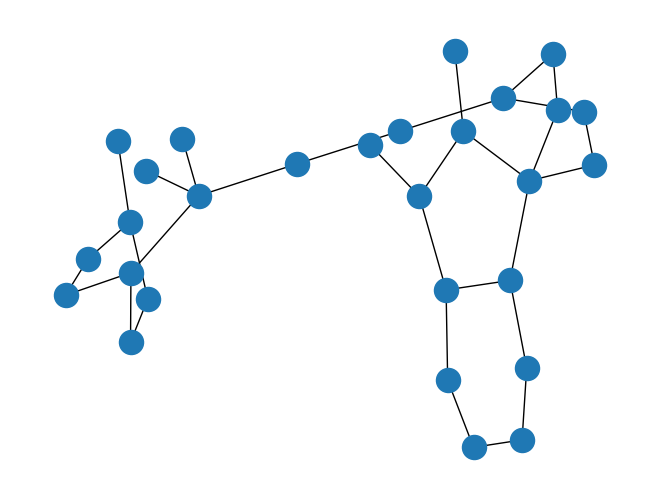

In [1]:
from datasets import load_dataset

# There is only one split on the hub
dataset = load_dataset("OGB/ogbg-molhiv")

dataset = dataset.shuffle(seed=0)

import networkx as nx
import matplotlib.pyplot as plt

# We want to plot the first train graph
graph = dataset["train"][0]

edges = graph["edge_index"]
num_edges = len(edges[0])
num_nodes = graph["num_nodes"]

# Conversion to networkx format
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(num_edges)])

# Plot
nx.draw(G)


In [88]:
from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator

dataset_processed = dataset.map(preprocess_item, batched=False)


Map:   0%|          | 0/32901 [00:00<?, ? examples/s]


NameError: name 'algos_graphormer' is not defined

In [1]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("graph-ml", model="clefourrier/graphormer-base-pcqm4mv1")

/Users/modlee/miniconda3/envs/modlee310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/modlee/miniconda3/envs/modlee310/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


KeyError: "Unknown task graph-ml, available tasks are ['audio-classification', 'automatic-speech-recognition', 'conversational', 'depth-estimation', 'document-question-answering', 'feature-extraction', 'fill-mask', 'image-classification', 'image-feature-extraction', 'image-segmentation', 'image-to-image', 'image-to-text', 'mask-generation', 'ner', 'object-detection', 'question-answering', 'sentiment-analysis', 'summarization', 'table-question-answering', 'text-classification', 'text-generation', 'text-to-audio', 'text-to-speech', 'text2text-generation', 'token-classification', 'translation', 'video-classification', 'visual-question-answering', 'vqa', 'zero-shot-audio-classification', 'zero-shot-classification', 'zero-shot-image-classification', 'zero-shot-object-detection', 'translation_XX_to_YY']"

In [4]:
# Load model directly
from transformers import AutoTokenizer, GraphormerForGraphClassification

model = GraphormerForGraphClassification.from_pretrained("clefourrier/graphormer-base-pcqm4mv2")

KeyError: <class 'transformers.models.graphormer.configuration_graphormer.GraphormerConfig'>

In [90]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("graph-ml", model="clefourrier/graphormer-base-pcqm4mv2")

KeyError: "Unknown task graph-ml, available tasks are ['audio-classification', 'automatic-speech-recognition', 'conversational', 'depth-estimation', 'document-question-answering', 'feature-extraction', 'fill-mask', 'image-classification', 'image-feature-extraction', 'image-segmentation', 'image-to-image', 'image-to-text', 'mask-generation', 'ner', 'object-detection', 'question-answering', 'sentiment-analysis', 'summarization', 'table-question-answering', 'text-classification', 'text-generation', 'text-to-audio', 'text-to-speech', 'text2text-generation', 'token-classification', 'translation', 'video-classification', 'visual-question-answering', 'vqa', 'zero-shot-audio-classification', 'zero-shot-classification', 'zero-shot-image-classification', 'zero-shot-object-detection', 'translation_XX_to_YY']"

In [69]:
from conftest import IMAGE_MODELS, IMAGE_SEGMENTATION_MODELS
model = IMAGE_SEGMENTATION_MODELS[2]
model = IMAGE_MODELS[0]
import modlee
converter = modlee.converter.Converter()

onnx_graph = converter.torch_model2onnx_graph(model)

In [71]:
%load_ext autoreload
%autoreload 2
onnx_graph
# dir(onnx_graph)
# print(dir(onnx_graph))
import torch_geometric
import matplotlib.pyplot as plt
# ax = plt.axes([0,0,5,10])
import networkx as nx 
import onnx
from onnx.tools import net_drawer
# print(onnx_graph.node)
onnx_pydot = onnx.tools.net_drawer.GetPydotGraph(
    converter.onnx_parameterless2onnx(onnx_graph).graph)
onnx_pydot.set_name("onnx_graph")
onnx_nx = nx.nx_pydot.from_pydot(onnx_pydot)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:

# dir(onnx_nx)
import matplotlib as mpl
import copy
def filter_nodes(x):
    return 'onnx::' in x \
        or 'Identity' in x \
        or 'fc.' in x
tensor_nodes = [k for k in onnx_nx.nodes.keys() if filter_nodes(k)]
# help(onnx_nx.remove_node)
onnx_nx_layers_only = copy.deepcopy(onnx_nx)
for tensor_node in tensor_nodes:
    onnx_nx_layers_only.remove_node(tensor_node)
print(onnx_nx_layers_only.nodes)
# pc = mpl.collections.PatchCollection(edges, cmap=cmap)
# pc.set_array(edge_colors)
# ax.show()
plt.show()
dir(onnx_nx_layers_only.edges)
# print(onnx_nx_layers_only.edges.keys())
e0 = onnx_nx_layers_only.edges.items()
print(e0)
onnx_nx.is_directed()
# print(onnx_nx.selfloop_edges)
n0 = list(onnx_nx.nodes.items())[0]
# print(n0[1])


['/conv1/Conv/Conv (op#0)\\n input0 input_1\\n input1 onnx', 'input_10', '/conv1/Conv_output_00', '/relu/Relu/Relu (op#1)\\n input0 /conv1/Conv_output_0\\n output0 /relu/Relu_output_0', '/relu/Relu_output_00', '/maxpool/MaxPool/MaxPool (op#2)\\n input0 /relu/Relu_output_0\\n output0 /maxpool/MaxPool_output_0', '/maxpool/MaxPool_output_00', '/layer1/layer1.0/conv1/Conv/Conv (op#3)\\n input0 /maxpool/MaxPool_output_0\\n input1 onnx', '/layer1/layer1.0/conv1/Conv_output_00', '/layer1/layer1.0/relu/Relu/Relu (op#4)\\n input0 /layer1/layer1.0/conv1/Conv_output_0\\n output0 /layer1/layer1.0/relu/Relu_output_0', '/layer1/layer1.0/relu/Relu_output_00', '/layer1/layer1.0/conv2/Conv/Conv (op#5)\\n input0 /layer1/layer1.0/relu/Relu_output_0\\n input1 onnx', '/layer1/layer1.0/conv2/Conv_output_00', '/layer1/layer1.0/Add/Add (op#6)\\n input0 /layer1/layer1.0/conv2/Conv_output_0\\n input1 /maxpool/MaxPool_output_0\\n output0 /layer1/layer1.0/Add_output_0', '/layer1/layer1.0/Add_output_00', '/layer1/

In [80]:
onnx_nx_layers_only.edges

OutMultiEdgeView([('/conv1/Conv/Conv (op#0)\\n input0 input_1\\n input1 onnx', '/conv1/Conv_output_00', 0), ('input_10', '/conv1/Conv/Conv (op#0)\\n input0 input_1\\n input1 onnx', 0), ('/conv1/Conv_output_00', '/relu/Relu/Relu (op#1)\\n input0 /conv1/Conv_output_0\\n output0 /relu/Relu_output_0', 0), ('/relu/Relu/Relu (op#1)\\n input0 /conv1/Conv_output_0\\n output0 /relu/Relu_output_0', '/relu/Relu_output_00', 0), ('/relu/Relu_output_00', '/maxpool/MaxPool/MaxPool (op#2)\\n input0 /relu/Relu_output_0\\n output0 /maxpool/MaxPool_output_0', 0), ('/maxpool/MaxPool/MaxPool (op#2)\\n input0 /relu/Relu_output_0\\n output0 /maxpool/MaxPool_output_0', '/maxpool/MaxPool_output_00', 0), ('/maxpool/MaxPool_output_00', '/layer1/layer1.0/conv1/Conv/Conv (op#3)\\n input0 /maxpool/MaxPool_output_0\\n input1 onnx', 0), ('/maxpool/MaxPool_output_00', '/layer1/layer1.0/Add/Add (op#6)\\n input0 /layer1/layer1.0/conv2/Conv_output_0\\n input1 /maxpool/MaxPool_output_0\\n output0 /layer1/layer1.0/Add_outp

/conv1/Conv/Conv (op#0)\n input0 input_1\n input1 onnx
{'shape': 'box', 'color': '#0F9D58', 'style': 'filled', 'fontcolor': '#FFFFFF'}


input_10
{'label': '"input_1"', 'shape': 'octagon'}


/conv1/Conv_output_00
{'label': '"/conv1/Conv_output_0"', 'shape': 'octagon'}


/relu/Relu/Relu (op#1)\n input0 /conv1/Conv_output_0\n output0 /relu/Relu_output_0
{'shape': 'box', 'color': '#0F9D58', 'style': 'filled', 'fontcolor': '#FFFFFF'}


/relu/Relu_output_00
{'label': '"/relu/Relu_output_0"', 'shape': 'octagon'}


/maxpool/MaxPool/MaxPool (op#2)\n input0 /relu/Relu_output_0\n output0 /maxpool/MaxPool_output_0
{'shape': 'box', 'color': '#0F9D58', 'style': 'filled', 'fontcolor': '#FFFFFF'}


/maxpool/MaxPool_output_00
{'label': '"/maxpool/MaxPool_output_0"', 'shape': 'octagon'}


/layer1/layer1.0/conv1/Conv/Conv (op#3)\n input0 /maxpool/MaxPool_output_0\n input1 onnx
{'shape': 'box', 'color': '#0F9D58', 'style': 'filled', 'fontcolor': '#FFFFFF'}


/layer1/layer1.0/conv1/Conv_output_00
{'label'

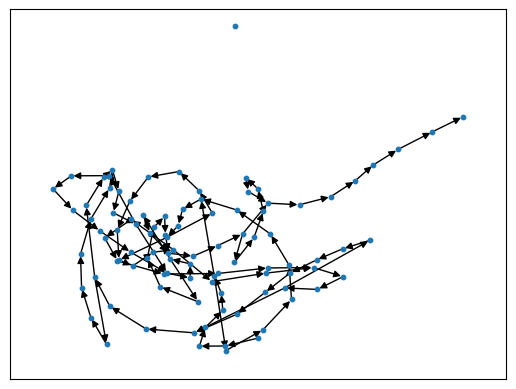

In [160]:
nodes_to_remove = []
for node_name, node_data in onnx_nx_layers_only.nodes.items():
    print(node_name)
    print(node_data)
    # if 'fontcolor' not in node_data:
    # if 'label' not in node_data:
    # if 'style' in node_data:
    #     nodes_to_remove.append(node_name)
        # onnx_nx_layers_only.remove_node(node_name)
    print('\n')

print(nodes_to_remove)
for node_to_remove in nodes_to_remove:
    onnx_nx_layers_only.remove_node(node_to_remove)
# n0 = onnx_nx.nodes[onnx_nx.nodes.keys()]
# edge_colors = range(2,onnx_nx_layers_only.number_of_edges()+2)
nx_drawing = nx.draw_networkx(onnx_nx_layers_only,
    pos=nx.spring_layout(onnx_nx_layers_only, seed=64),
    # pos=nx.bipartite_layout(onnx_nx),
    with_labels=False,
    node_size=10,
    # edge_color=edge_colors,
    # edge_cmap=plt.cm.plasma
    # ax=ax
)
print(onnx_nx_layers_only.edges)


In [267]:
dir(onnx_nx)
# dir(onnx_nx.nodes)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__networkx_cache__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adj',
 '_node',
 '_pred',
 '_succ',
 'add_edge',
 'add_edges_from',
 'add_node',
 'add_nodes_from',
 'add_weighted_edges_from',
 'adj',
 'adjacency',
 'adjlist_inner_dict_factory',
 'adjlist_outer_dict_factory',
 'clear',
 'clear_edges',
 'copy',
 'degree',
 'edge_attr_dict_factory',
 'edge_key_dict_factory',
 'edge_subgraph',
 'edges',
 'get_edge_data',
 'graph',
 'graph_attr_dict_factory',
 'has_edge',
 'has_node',
 'has_predecessor',
 'has_successor',
 'in_degree',
 'in_edges',
 'is_directed',
 'is_mult

In [270]:
for node_name, node_data in onnx_nx.nodes.items():
    # type(node_data)
    print(onnx_nx.nodes[node_name])

{'shape': 'box', 'color': '#0F9D58', 'style': 'filled', 'fontcolor': '#FFFFFF'}
{'label': '"input_1"', 'shape': 'octagon'}
{'label': '"onnx::Conv_193"', 'shape': 'octagon'}
{'label': '"onnx::Conv_194"', 'shape': 'octagon'}
{'label': '"/conv1/Conv_output_0"', 'shape': 'octagon'}
{'shape': 'box', 'color': '#0F9D58', 'style': 'filled', 'fontcolor': '#FFFFFF'}
{'label': '"/relu/Relu_output_0"', 'shape': 'octagon'}
{'shape': 'box', 'color': '#0F9D58', 'style': 'filled', 'fontcolor': '#FFFFFF'}
{'label': '"/maxpool/MaxPool_output_0"', 'shape': 'octagon'}
{'shape': 'box', 'color': '#0F9D58', 'style': 'filled', 'fontcolor': '#FFFFFF'}
{'label': '"onnx::Conv_196"', 'shape': 'octagon'}
{'label': '"onnx::Conv_197"', 'shape': 'octagon'}
{'label': '"/layer1/layer1.0/conv1/Conv_output_0"', 'shape': 'octagon'}
{'shape': 'box', 'color': '#0F9D58', 'style': 'filled', 'fontcolor': '#FFFFFF'}
{'label': '"/layer1/layer1.0/relu/Relu_output_0"', 'shape': 'octagon'}
{'shape': 'box', 'color': '#0F9D58', 'styl

OutMultiEdgeView([('/conv1/Conv/Conv (op#0)\\n input0 input_1\\n input1 onnx', '/conv1/Conv_output_00', 0), ('input_10', '/conv1/Conv/Conv (op#0)\\n input0 input_1\\n input1 onnx', 0), ('/conv1/Conv_output_00', '/relu/Relu/Relu (op#1)\\n input0 /conv1/Conv_output_0\\n output0 /relu/Relu_output_0', 0), ('/relu/Relu/Relu (op#1)\\n input0 /conv1/Conv_output_0\\n output0 /relu/Relu_output_0', '/relu/Relu_output_00', 0), ('/relu/Relu_output_00', '/maxpool/MaxPool/MaxPool (op#2)\\n input0 /relu/Relu_output_0\\n output0 /maxpool/MaxPool_output_0', 0), ('/maxpool/MaxPool/MaxPool (op#2)\\n input0 /relu/Relu_output_0\\n output0 /maxpool/MaxPool_output_0', '/maxpool/MaxPool_output_00', 0), ('/maxpool/MaxPool_output_00', '/layer1/layer1.0/conv1/Conv/Conv (op#3)\\n input0 /maxpool/MaxPool_output_0\\n input1 onnx', 0), ('/maxpool/MaxPool_output_00', '/layer1/layer1.0/Add/Add (op#6)\\n input0 /layer1/layer1.0/conv2/Conv_output_0\\n input1 /maxpool/MaxPool_output_0\\n output0 /layer1/layer1.0/Add_outp

tensor([[41.9631, 38.9056, 36.7698,  ..., 15.8812, 28.5670, 18.8990],
        [41.9631, 38.9056, 36.7698,  ..., 15.8812, 28.5670, 18.8990],
        [41.9631, 38.9056, 36.7698,  ..., 15.8812, 28.5670, 18.8990],
        ...,
        [41.9631, 38.9056, 36.7698,  ..., 15.8812, 28.5670, 18.8990],
        [41.9631, 38.9056, 36.7698,  ..., 15.8812, 28.5670, 18.8990],
        [41.9631, 38.9056, 36.7698,  ..., 15.8812, 28.5670, 18.8990]],
       dtype=torch.float64)

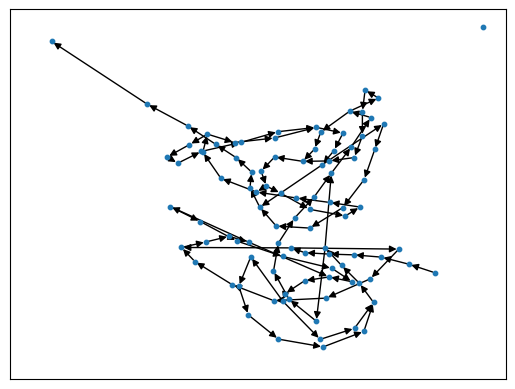

In [309]:
# import torch_geometric as pyg
import torch_geometric as pyg
# print(pyg.__version__)
# dir(pyg)
# dir(torch_geometric.torch_geometric)
# from torch_geometric.utils import convert
onnx_test = copy.deepcopy(onnx_nx_layers_only)
# nx.set_node_attributes(onnx_test, None, "label")
edge_dict = {'shape': 'box', 'color': '#0F9D58', 'style': 'filled', 'fontcolor': '#FFFFFF', 'label': None}
for k in edge_dict.keys():
    # nx.set_node_attributes(onnx_test, None, k)
    nx.set_node_attributes(onnx_test, np.random.rand(98)*100, k)
    nx.set_node_attributes(onnx_test, np.random.rand()*100, f"edge_{k}")
# dir(onnx_test.edges.items()[0])
onnx_test.edges
# for edge_name,edge_data in onnx_test.edges.items():
#     print(edge_data)
# nx.get_edge_attributes(onnx_test)
nx.draw_networkx(onnx_test,
    with_labels=False,
        node_size=10,
    )
# for node,node_data in onnx_test.nodes.items():
#     print(node_data)
onnx_pyg = pyg.utils.convert.from_networkx(
    onnx_test,
    group_node_attrs=['label'],
    group_edge_attrs=['shape']
    )
# !ls
# onnx_pyg.label
# dir(onnx_pyg)
# onnx_pyg.fully_specify()
onnx_pyg.x
# onnx_pyg.get_tensor()
# onnx_pyg.num_node_features

In [308]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# dir(onnx_pyg)
onnx_pyg.edge_attrs()
onnx_pyg.is_directed()
# onnx_pyg.num_nodes  
# onnx_pyg.num_node_features

['edge_index']

IndexError: index 98 is out of bounds for dimension 0 with size 98

In [15]:
pyg.nn.model_hub()

[autoreload of importlib_metadata._adapters failed: Traceback (most recent call last):
  File "/Users/modlee/miniconda3/envs/modlee3.12/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/modlee/miniconda3/envs/modlee3.12/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/modlee/miniconda3/envs/modlee3.12/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/modlee/miniconda3/envs/modlee3.12/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/modlee/miniconda3/envs/modlee3.12/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/modlee/min

NameError: name 'pyg' is not defined

In [67]:
# nx.
# nx.from_graph6_bytes(onnx_graph.graph)
# dir(onnx_graph.graph)
# onnx_graph.graph.SerializeToString()
# nx.from
# type(onnx_graph.graph)
# onnx.numpy_helper.to_dict(onnx_graph.graph)

AttributeError: key_type

In [13]:
from transformers import GraphormerForGraphClassification

model = GraphormerForGraphClassification.from_pretrained(
    "clefourrier/pcqm4mv2_graphormer_base",
    num_classes=1, # num_classes for the downstream task 
    ignore_mismatched_sizes=True,
)



In [318]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch_geometric.nn import GCNConv

from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
# dataset = DataLoader([onnx_pyg])

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
        # self.conv1 = GCNConv(98, 16)
        # self.conv1 = GCNConv(98, 1)
        # self.conv1 = GCNConv(1, 16)
        # self.conv2 = GCNConv(16, dataset.num_classes)
        # self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

gcn = GCN()


In [279]:
type(dataset)
type(onnx_pyg)

torch_geometric.datasets.planetoid.Planetoid

torch_geometric.data.data.Data

In [322]:
dataset[0].x.min()
gcn(dataset[0])

tensor(0.)

tensor([[-2.0792, -1.9235, -1.9140,  ..., -2.0258, -1.9088, -1.9174],
        [-2.1455, -1.9914, -2.0584,  ..., -1.8971, -1.7810, -1.8307],
        [-2.0636, -1.9804, -1.9188,  ..., -1.9784, -1.8886, -1.9428],
        ...,
        [-1.9716, -1.9535, -1.9079,  ..., -1.9595, -1.9411, -1.9435],
        [-2.0506, -2.0383, -1.8578,  ..., -1.9852, -1.8683, -1.9095],
        [-2.0138, -1.9649, -1.9187,  ..., -1.9870, -1.9010, -1.9092]],
       grad_fn=<LogSoftmaxBackward0>)

In [334]:
# dir(pyg.nn.models)
# pyg_unet = pyg.nn.models.GraphUNet()
pyg_models = pyg.nn.models
for pyg_model in dir(pyg_models):
    # print(pyg_model)
    # dir(pyg_model)
    if 'pretrained' in ' '.join((dir(getattr(pyg_models,pyg_model)))):
        print(pyg_model)

DimeNet
DimeNetPlusPlus
SchNet


In [343]:
import argparse
import os.path as osp

import torch

from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import DimeNet, DimeNetPlusPlus

Model = DimeNetPlusPlus

# path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'QM9')
path = osp.join(osp.dirname(osp.abspath('')), '..', 'data', 'QM9')
dataset = QM9(path)

# DimeNet uses the atomization energy for targets U0, U, H, and G, i.e.:
# 7 -> 12, 8 -> 13, 9 -> 14, 10 -> 15
idx = torch.tensor([0, 1, 2, 3, 4, 5, 6, 12, 13, 14, 15, 11])
dataset.data.y = dataset.data.y[:, idx]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [344]:

for target in range(12):
    # Skip target \delta\epsilon, since it can be computed via
    # \epsilon_{LUMO} - \epsilon_{HOMO}:
    if target == 4:
        continue

    model, datasets = Model.from_qm9_pretrained(path, dataset, target)
    train_dataset, val_dataset, test_dataset = datasets

    model = model.to(device)
    loader = DataLoader(test_dataset, batch_size=256)

    maes = []
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data.z, data.pos, data.batch)
        mae = (pred.view(-1) - data.y[:, target]).abs()
        maes.append(mae)

    mae = torch.cat(maes, dim=0)

    # Report meV instead of eV:
    mae = 1000 * mae if target in [2, 3, 4, 6, 7, 8, 9, 10] else mae

    print(f'Target: {target:02d}, MAE: {mae.mean():.5f} ± {mae.std():.5f}')

TypeError: A Message class can only inherit from Message, not (<class 'google.protobuf.message.Message'>,)

In [323]:
# dataset[0].num_node_features
dataset[0].edge_index
# dataset[0].num_features
# dataset[0].x
onnx_pyg.edge_index
# onnx_pyg.x
type(dataset[0]); type(onnx_pyg)
onnx_pyg.x.max()
onnx_pyg.num_nodes
# onnx_pyg.num_node_features = onnx_pyg.num_nodes
onnx_pyg.num_node_features
# [onnx_pyg].num_node_features
# type(dataset)
# help(torch_geometric.datasets)
# gcn(dataset[0])
# pyg_data = onnx_pyg.unsqueeze(-1)
BATCH_SIZE = 32
class PyGDataset(torch.utils.data.Dataset):
    def __init__(self, *args, **kwargs):
        pass
    
    def __len__(self):
        return BATCH_SIZE
    
    def __getitem__(self, idx):
        return onnx_pyg


pyg_dataset = DataLoader(PyGDataset(), batch_size=BATCH_SIZE)
# pyg_batch = next(iter(pyg_dataset))
# [torch.Tensor(onnx_pyg)]*10
# onnx_pyg*10
pyg_batch_list = pyg.data.Batch.from_data_list([onnx_pyg]*32)
gcn_out = gcn(pyg_batch_list)
# gcn_out = gcn(torch.Tensor(onnx_pyg))
gcn_out.shape
gcn_out

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

tensor([[ 0,  1,  2,  3,  4,  5,  6,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 26, 27, 28, 29, 30, 31, 32,
         33, 34, 35, 36, 37, 38, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 48,
         49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 60, 61, 62, 63, 64, 65,
         66, 67, 68, 69, 70, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
         82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95],
        [ 2,  0,  3,  4,  5,  6,  7, 13,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         23, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 28, 29, 30, 31, 32, 35,
         34, 35, 36, 37, 38, 39, 45, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 55,
         50, 51, 52, 53, 54, 57, 56, 57, 58, 59, 60, 61, 67, 62, 63, 64, 65, 66,
         67, 68, 69, 70, 71, 77, 72, 73, 74, 75, 76, 79, 78, 79, 80, 81, 82, 83,
         89, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]])

torch_geometric.data.data.Data

torch_geometric.data.data.Data

tensor(96.7377, dtype=torch.float64)

98

98

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3136x98 and 1433x16)

# ONNX -> PyDot -> NetworkX -> PyG

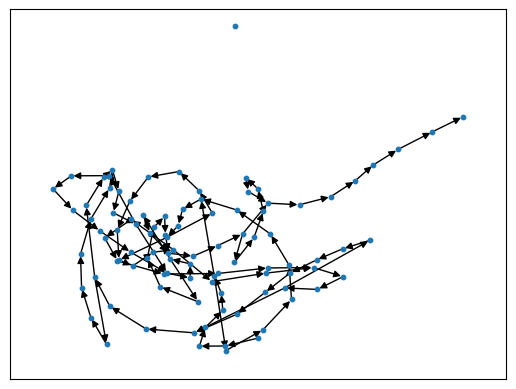

In [302]:
onnx_pyg_nx = pyg.utils.convert.to_networkx(
    onnx_pyg,
    
)

nx.draw_networkx(onnx_pyg_nx,
    pos=nx.spring_layout(onnx_pyg_nx, seed=64),
    with_labels=False,
    node_size=10)

# for node_name, node_data in onnx_pyg_nx.nodes.items():
#     print(node_data)

## Graph from ONNX -> PyDot -> NetworkX

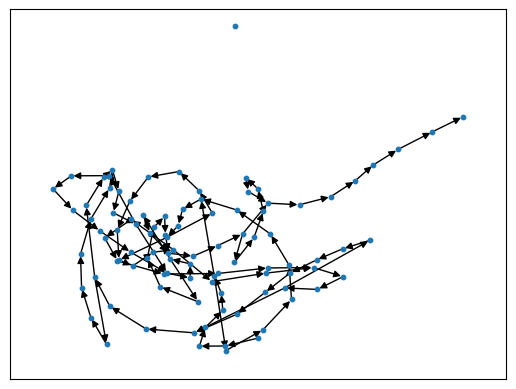

In [142]:

nx.draw_networkx(onnx_pyg_nx,
    pos=nx.spring_layout(onnx_pyg_nx, seed=64),
    with_labels=False,
    node_size=10)

## Graph from ONNX -> PyDot -> NetworkX -> PyG -> NetworkX